# Модели машинного обучения различной архитектуры: простейший пример

**Полезные ссылки:**

- Метод K ближайших соседей (K Nearest Neighbors, KNN)
    - Документация [KNeighborsRegressor в sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
    - StatQuest (YouTube): [K-nearest neighbors, Clearly Explained](https://www.youtube.com/watch?v=HVXime0nQeI)
- Модели Гаусовых процессов (Gaussian process models):
    - Документация [GaussianProcessRegressor в sklearn](https://scikit-learn.org/dev/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)
    - Наглядное объяснение общей идеи ([YouTube](https://www.youtube.com/watch?v=iDzaoEwd0N0))
    - Про ковариационные функции: [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)
- Деревья решений (Desision Trees):
    - Документация [DecisionTreeRegressor в sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
    - StatQuest (YouTube): [Decision and Classification Trees, Clearly Explained](https://www.youtube.com/watch?v=_L39rN6gz7Y)
- Метод опорных векторов (Support Vector Machine)
    - Документация [SVR в sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.svm.SVR.html)
    - StatQuest (YouTube): [Support Vector Machines Part 1](https://www.youtube.com/watch?v=efR1C6CvhmE)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge   
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150

## Генерация данных 

Порождаем синтетические данные с линейной зависимость y от x (используем для этого слегка модифицированную функцию generate_data из синтетических прошлых примеров).

Text(0, 0.5, 'Y')

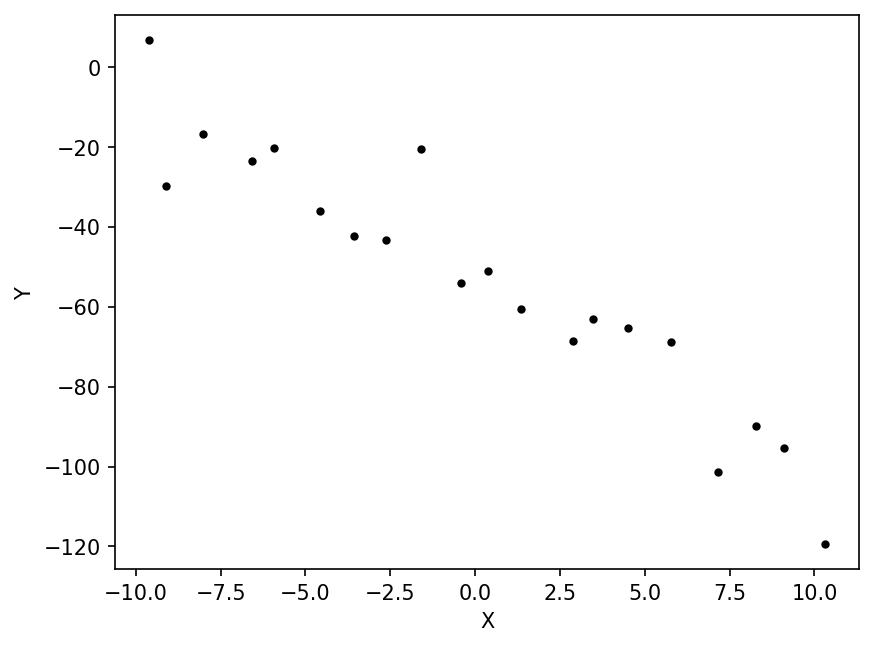

In [13]:
def generate_data (sample_size = 40):
    
    #true_degee = 4; true_theta = [0, -2.5, -1.9, -0.019, 0.021]
    #true_degee = 3; true_theta = [-50, -4, 1.9, 0.25]
    #true_degee = 2; true_theta = [-50, -4, 1.9] 
    true_degee = 1; true_theta = [-50, -4] #, 1.9] 

    
    #X = np.random.rand(sample_size) * 20 - 10
    X = np.linspace(-10, 10, sample_size) + np.random.randn(sample_size)*0.25
    
    poly = PolynomialFeatures(true_degee)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
 
    Y = np.dot(X_poly, true_theta) + np.random.randn(sample_size) * 10 #+ np.random.randn(sample_size) * np.sqrt (np.abs(X)) * 2
    return X,Y


X, Y = generate_data(20)

plt.figure()
plt.plot(X, Y, '.k')
plt.xlabel('X')
plt.ylabel('Y')


## Функции для сравнения моделей  

Порождаем синтетические данные с линейной зависимость y от x (используем для этого слегка модифицированную функцию generate_data из синтетических прошлых примеров).

In [ ]:
def evaluate_model (model, X, Y, X_smooth, ax):
    model.fit(X.reshape(-1,1), Y) 
    Y_predicted = model.predict(X.reshape(-1,1))
    
    rmse = np.sqrt(mean_squared_error(Y, Y_predicted))
    r2 = r2_score(Y, Y_predicted)
    
    Y_predicted_smooth = model.predict(X_smooth.reshape(-1,1))

    ax.tick_params(axis='x', labelsize='x-small')
    ax.tick_params(axis='y', labelsize='x-small')
    ax.plot(X, Y, 'ok')
    ax.plot(X_smooth, Y_predicted_smooth, '-r')

    ax.set_title (model.__class__.__name__ + '\nRMSE = %.2f, r2 = %.2f'%(rmse, r2), fontsize='small')
    #plt.suptitle('Degree = %d, scaler = %s, number of samples = %d'%(model.degree, model.scaler.__class__.__name__, Y.shape[0]))

def compare_models (models, X, Y, margin = 0):
    fig, ax = plt.subplots(2,3)

    delta_x = (X.flatten().max()-X.flatten().min())

    X_smooth = np.linspace(X.flatten().min()-margin*delta_x, X.flatten().max()+margin*delta_x, 10000)
    
    for i, model in enumerate (models):

        another_model = models[0] if i > 0 else models[1]
        if model.__class__.__name__ == another_model.__class__.__name__:
            params1 = model.get_params()
            params2 = another_model.get_params()
            try:
                diff_params = {key: params1[key] for key in params1 if params1[key] != params2[key]}
                hp_str = ''.join([str(key) + '=' + str(value) + '\n' for key, value in zip (diff_params.keys(), diff_params.values()) if key not in ['kernel__length_scale']]) #diff_params)
            except:
                hp_str = ''
        else:
            hp_str = ''

        evaluate_model (model, X, Y, X_smooth, ax.flatten()[i])
        if hp_str != '':
            ax.flatten()[i].set_title (ax.flatten()[i].title.get_text() + '\n' + hp_str, fontsize='small')

    plt.tight_layout()


## Сравним модели разных типов c гиперпараметрами, заданными по умолчанию

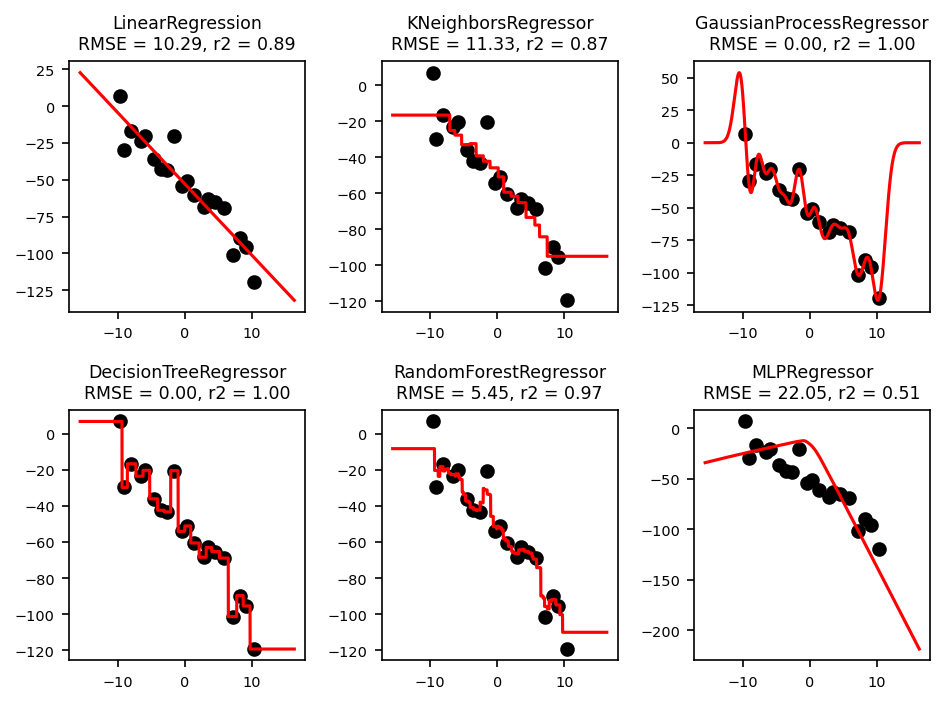

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

svr_pl = Pipeline([
                  ('scaler', StandardScaler()),  # scaler for features
                  ('model', TransformedTargetRegressor(regressor=SVR(), transformer=StandardScaler()))  # model
                  ])

#         

models = [LinearRegression(),
          KNeighborsRegressor(), #weights='distance'),
          GaussianProcessRegressor(),  #
          DecisionTreeRegressor (),
          RandomForestRegressor(),
          MLPRegressor(hidden_layer_sizes=(100,100,100))] #svr_tr]


compare_models (models, X, Y, 0.3)


## Метод K ближайших соседей

Посмотрим, как ведет себя модель при разных k

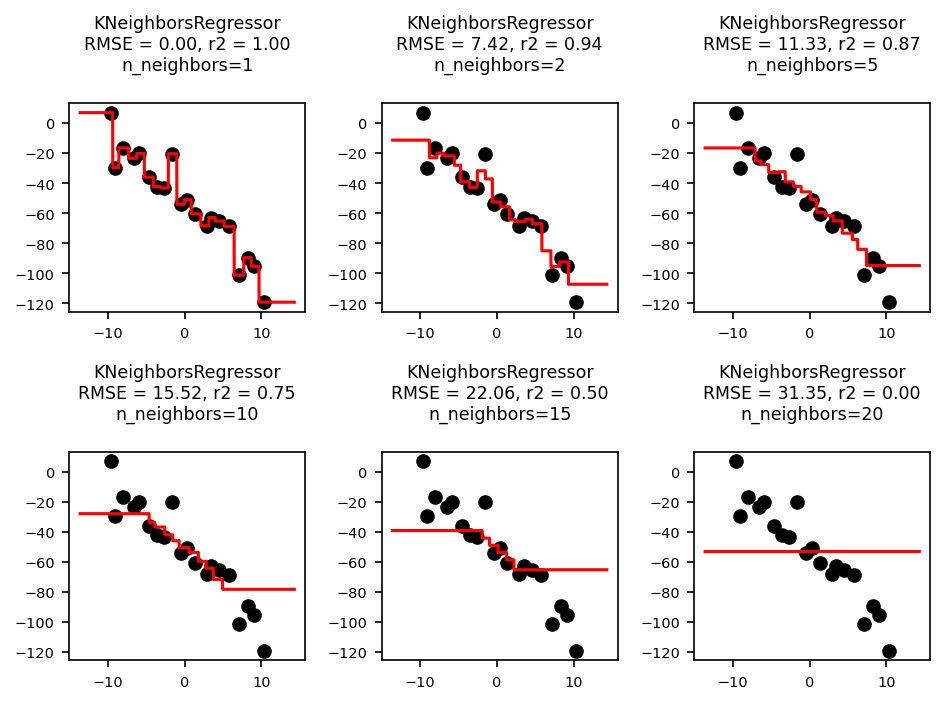

In [20]:
models = [KNeighborsRegressor(n_neighbors=x) for x in [1,2,5,10,15,20]]
compare_models (models, X, Y, 0.2)

## Деревья решений

Сравним деревья решений с различными гиперпараметрами

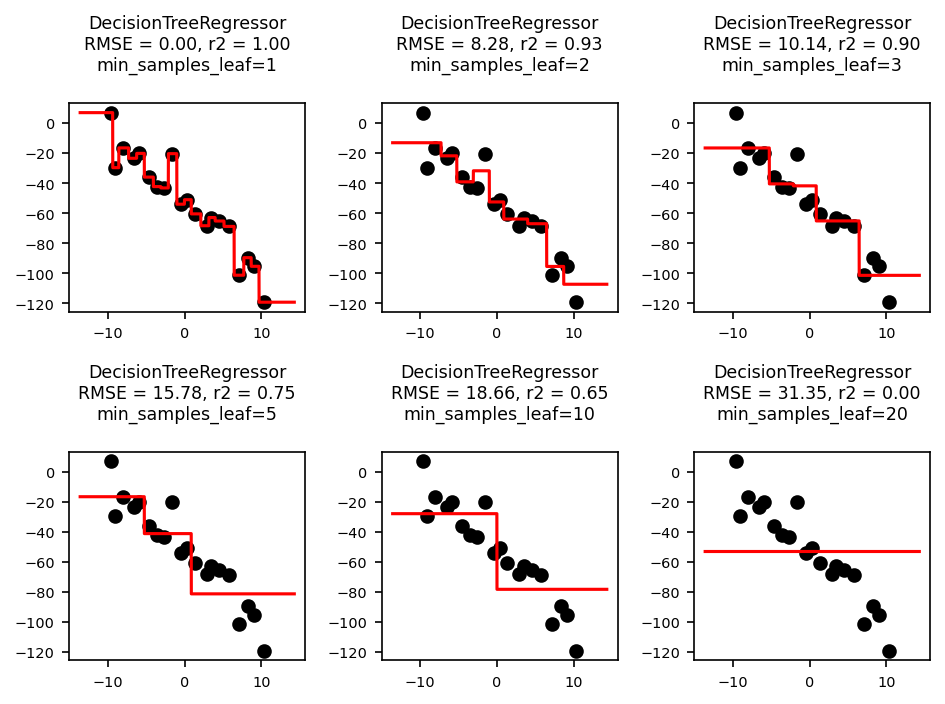

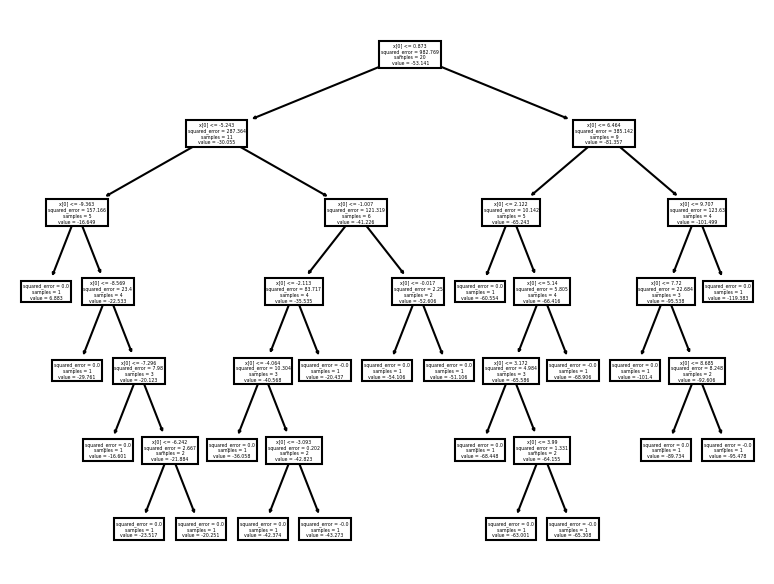

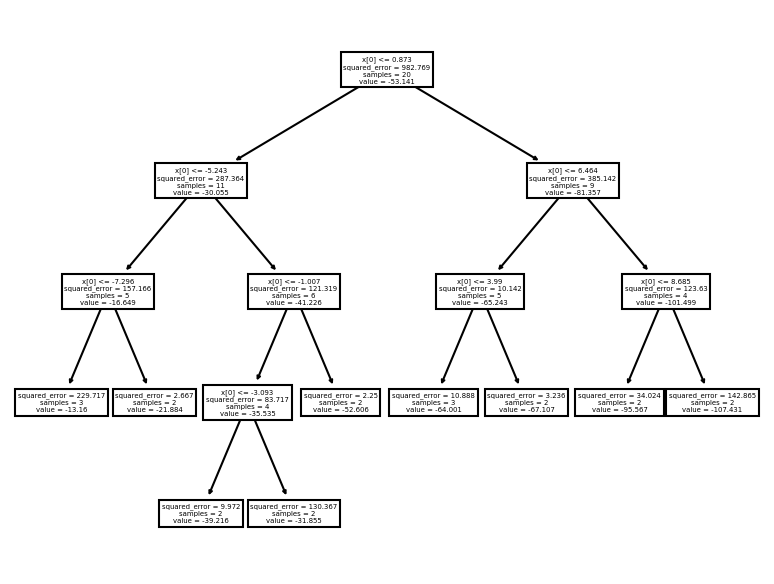

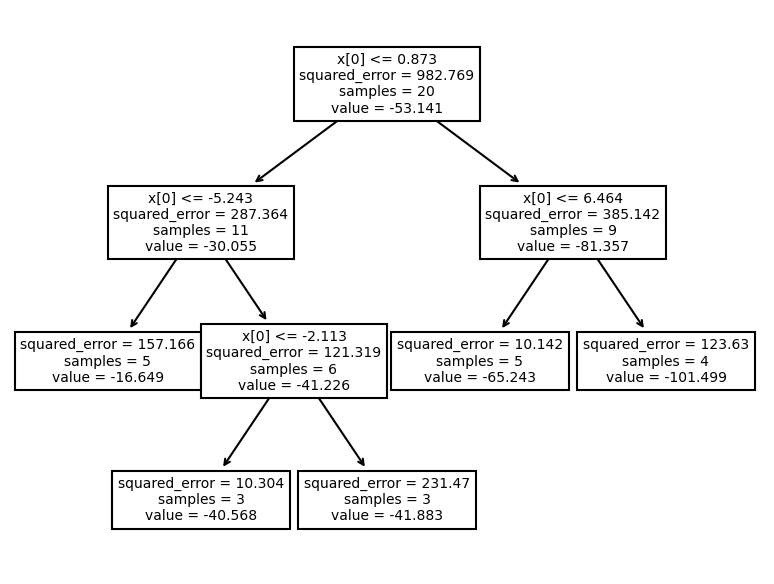

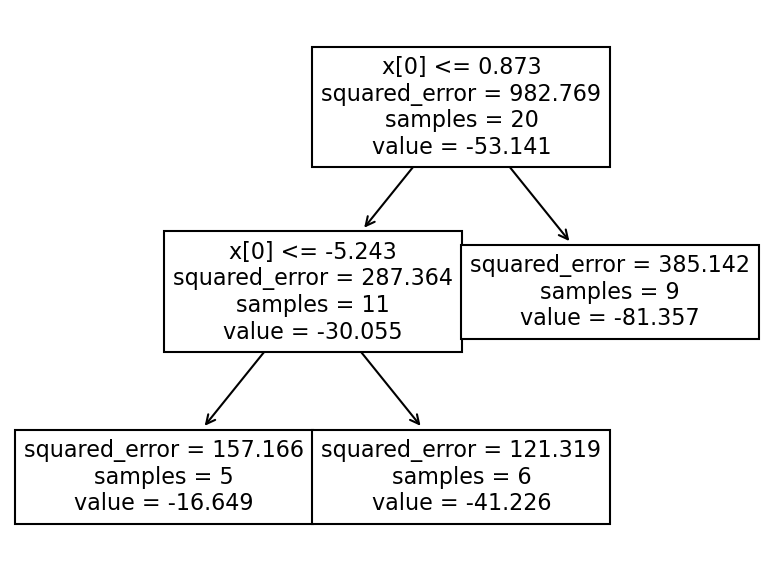

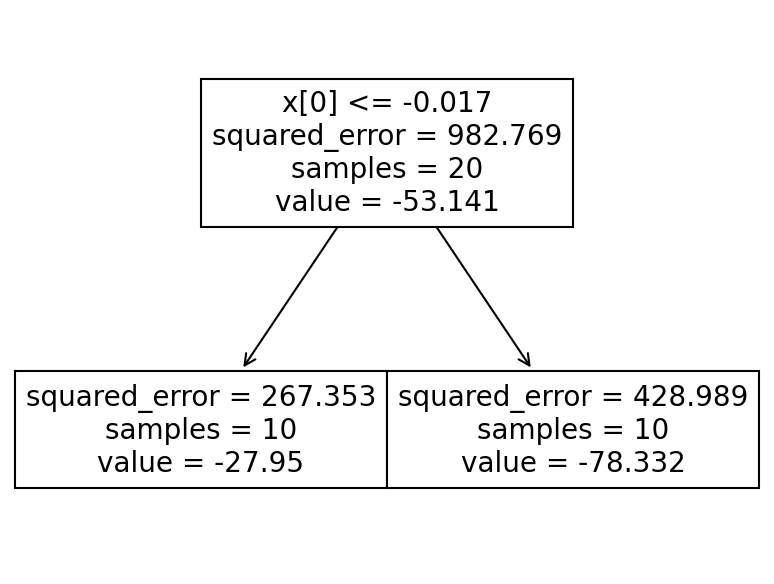

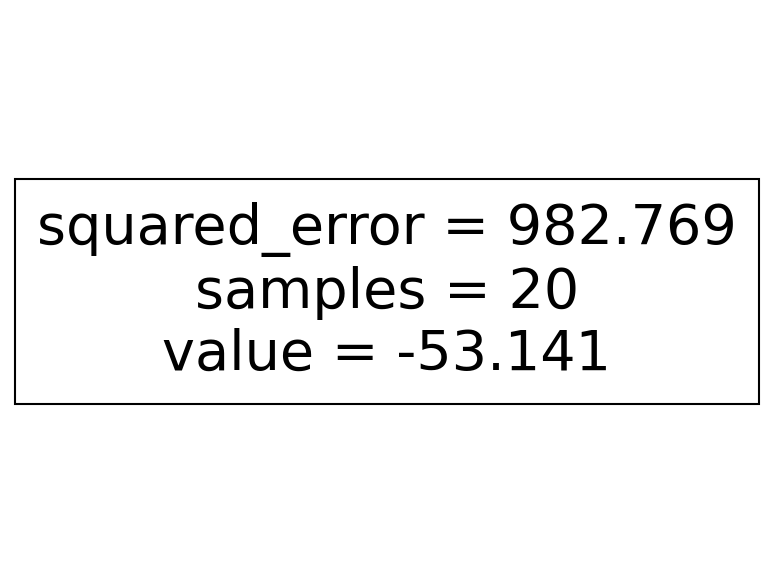

In [22]:
#models = [DecisionTreeRegressor (max_depth=x) for x in [1,2,3,5,10,20]]
models = [DecisionTreeRegressor (min_samples_leaf=x) for x in [1,2,3,5,10,20]]

compare_models (models, X, Y, 0.2)

for model in models:
    plt.figure()
    plot_tree(model)

## Гауссовы процессы


c:\Anaconda\envs\ML\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


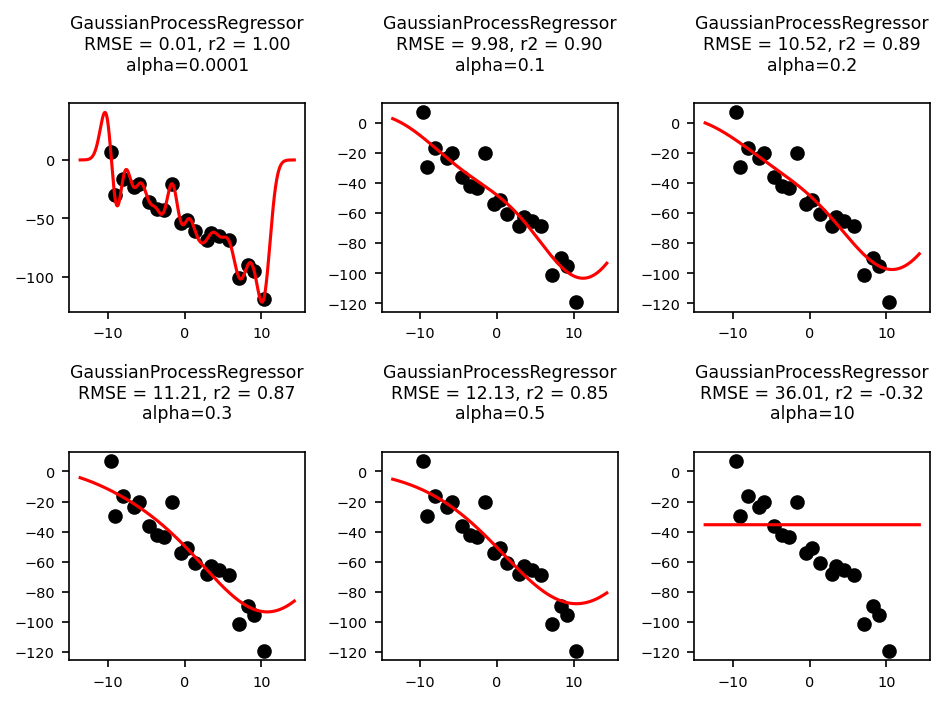

In [26]:
#models = [GaussianProcessRegressor (kernel=ConstantKernel() + RBF(x, length_scale_bounds='fixed')) for x in [0.1,0.2,0.3,0.5,1,2]]
models = [GaussianProcessRegressor (kernel = RBF(), alpha = x) for x in [0.0001, 0.1,0.2,0.3,0.5,10]]

compare_models (models, X, Y, 0.2)